#Preparation

In [1]:
! Pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
! unzip -q -o /content/alzheimers-dataset-4-class-of-images.zip -d /content/sample_data/

! pip install -q git+https://github.com/paaatcha/raug
! pip install -q pretrainedmodels
! pip install -q efficientnet_pytorch
! pip install -q tensorboardX
! pip install -q python-telegram-bot
! pip install -U imbalanced-learn

/bin/bash: line 1: Pip: command not found
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images
License(s): ODbL-1.0
 97% 33.0M/34.1M [00:02<00:00, 18.8MB/s]
100% 34.1M/34.1M [00:02<00:00, 13.8MB/s]
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

# Imports

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms, utils
from tqdm import tqdm
import os
import pandas as pd
from PIL import Image
import numpy as np
from raug import loader
from raug.models import resnet, vggnet, senet, load_model
from raug.train import fit_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, roc_curve, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from skimage.io import imread
import seaborn as sns

SEED = 20
torch.manual_seed(SEED)
np.random.seed(SEED)

# Data preprocessing

In [3]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/content/sample_data/Alzheimer_s Dataset')):
    subfolder_path = os.path.join('/content/sample_data/Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'path': images, 'label': labels})
df.label = df.label.astype('category')
df.head()

100%|██████████| 2/2 [00:00<00:00, 75.46it/s]


,path,label
0,/content/sample_data/Alzheimer_s Dataset/train...,NonDemented
1,/content/sample_data/Alzheimer_s Dataset/train...,NonDemented
2,/content/sample_data/Alzheimer_s Dataset/train...,NonDemented
3,/content/sample_data/Alzheimer_s Dataset/train...,NonDemented
4,/content/sample_data/Alzheimer_s Dataset/train...,NonDemented


In [4]:
X_path, y = df.path.values, df.label.values
X = np.array([imread(x) for x in X_path])

print(X.shape, y.shape)

(6400, 208, 176) (6400,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=SEED, stratify=y_train)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3584, 208, 176) (3584,)
(1536, 208, 176) (1536,)
(1280, 208, 176) (1280,)


## Data balancing

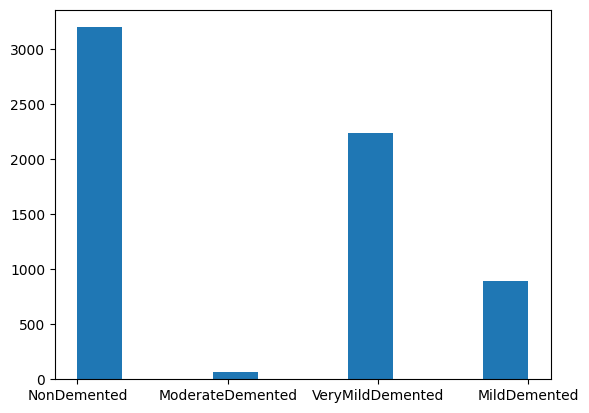

In [6]:
plt.hist(y)
plt.show()

(7168, 208, 176)


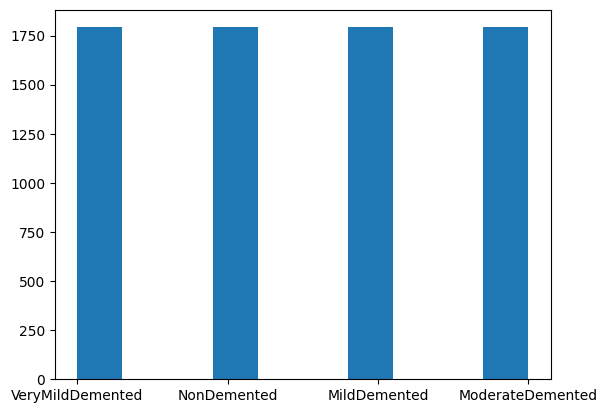

In [7]:
X_train = X_train.reshape(-1, 208 * 176)

smt = SMOTE(random_state=SEED)
X_train, y_train = smt.fit_resample(X_train, y_train)

X_train = X_train.reshape(-1, 208, 176)

print(X_train.shape)
plt.hist(y_train)
plt.show()

## Creating dataset and dataloader

In [8]:
train_labels_cat, train_labels_int = np.unique(y_train, return_inverse=True)
val_labels_cat, val_labels_int = np.unique(y_val, return_inverse=True)
test_labels_cat, test_labels_int = np.unique(y_test, return_inverse=True)

In [9]:
class MyDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        super().__init__()
        self.imgs = imgs
        self.labels = labels

        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()


    def __len__(self):
        return len(self.imgs)


    def __getitem__(self, item):
        image = self.imgs[item]

        # Applying the transformations
        image = Image.fromarray(image)
        image = image.convert(mode='RGB')

        image = self.transform(image)

        labels = self.labels[item]

        return image, labels

In [10]:
transf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = MyDataset(X_train, train_labels_int, transform=transf)
val_dataset = MyDataset(X_val, val_labels_int, transform=transf)
test_dataset = MyDataset(X_test, test_labels_int, transform=transf)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Data visualization

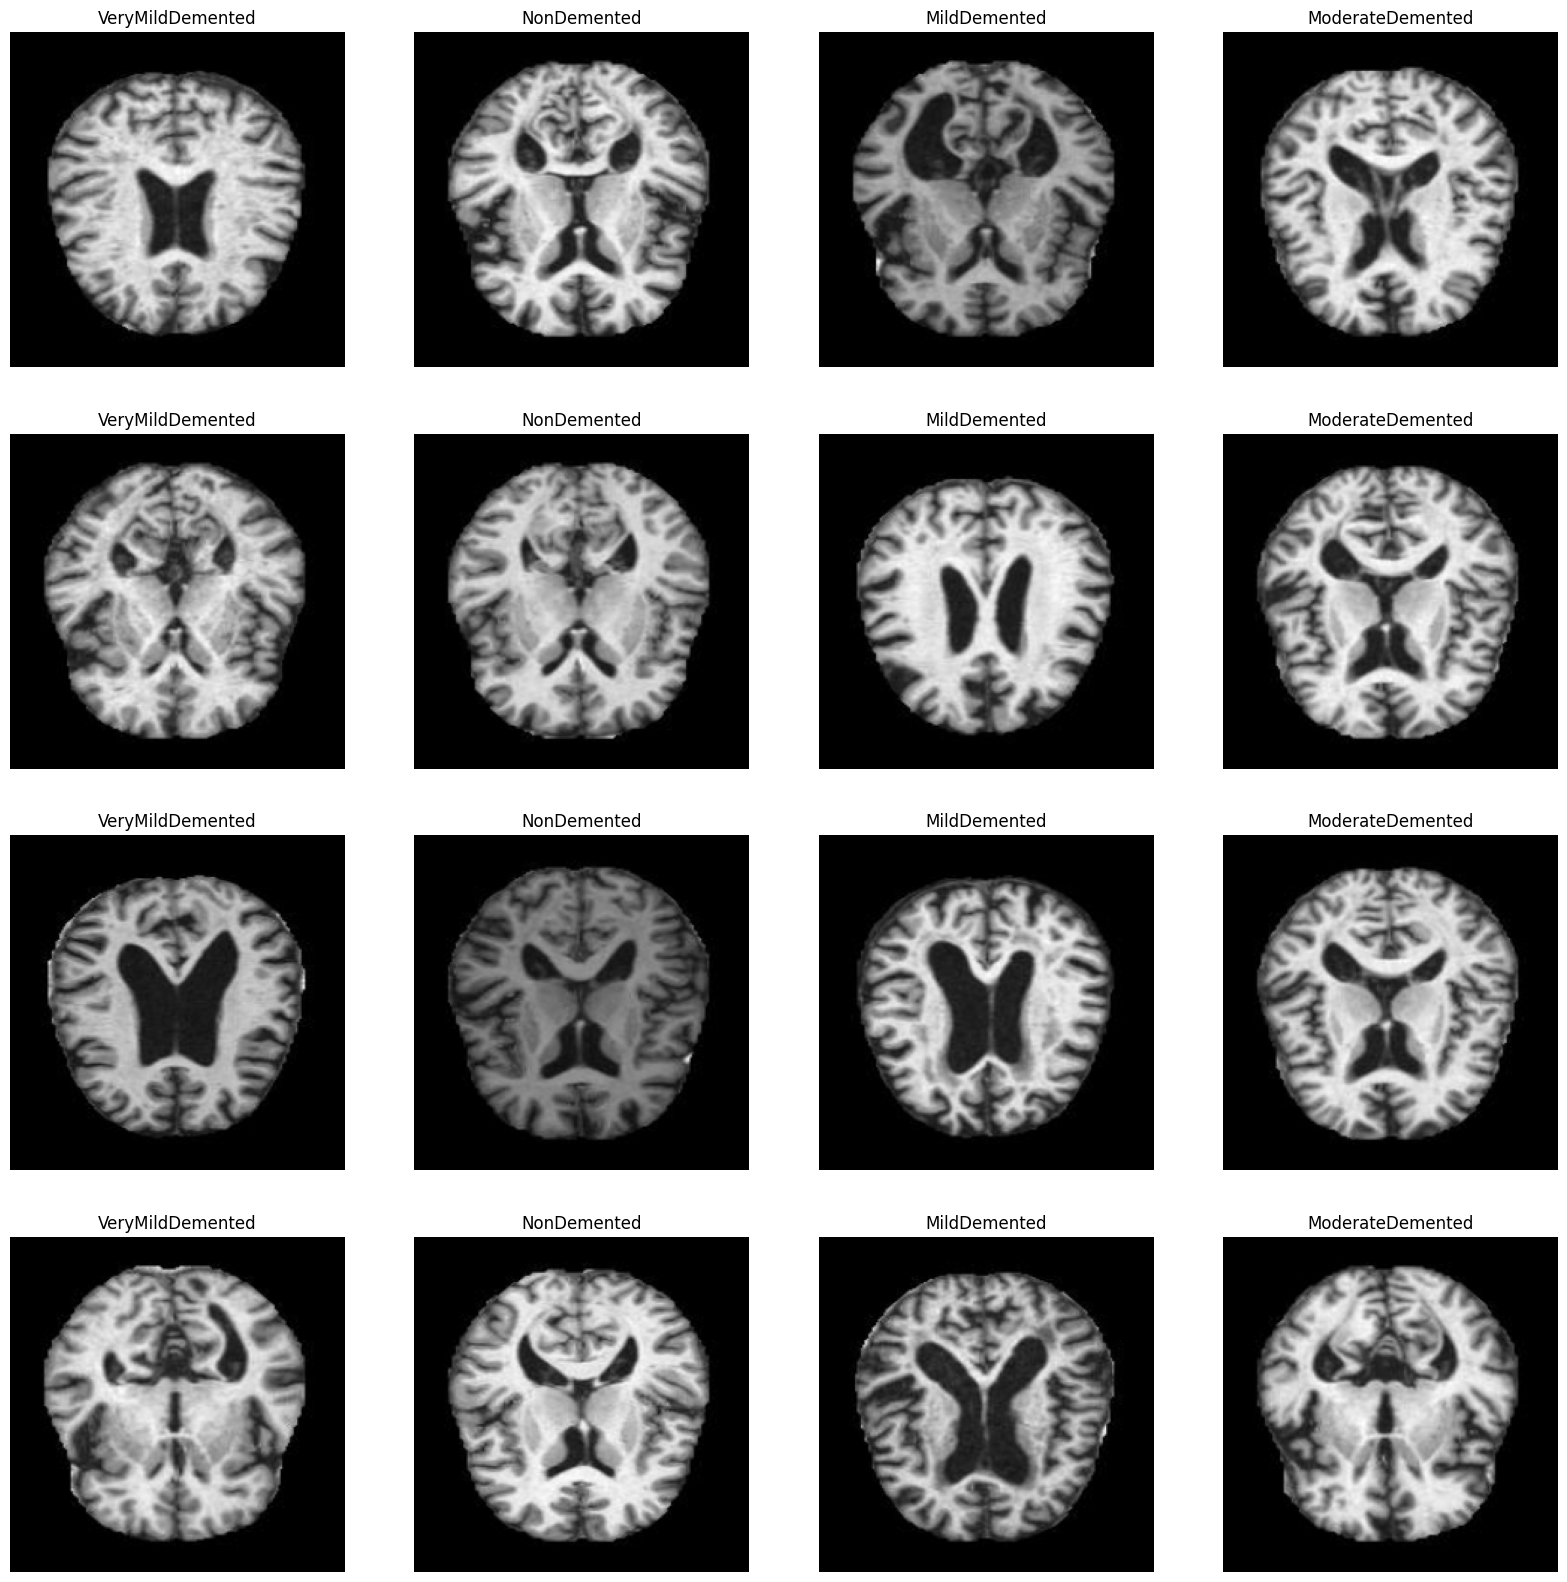

In [11]:
all_img = {}

for images, labels in test_dataloader:
    classes = test_labels_cat[labels]
    for image, label in zip(images, classes):
        if all_img.get(label) is None:
            all_img[label] = []

        all_img[label].append(image)

plt.figure(figsize= (20, 20))

for i in range(4):
    for j, label in enumerate(all_img.keys(), 0):
        plt.subplot(4, 4, j + i*4 + 1)
        image = np.transpose(all_img[label][i].numpy(), (1,2,0))
        plt.imshow(image)
        plt.title(label, fontsize= 12)
        plt.axis('off')

# Training

## ResNet

In [12]:
resnet_model = resnet.MyResnet(torchvision.models.resnet50(pretrained=True), 4, freeze_conv=False)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 69.3MB/s]


In [14]:
fit_model(resnet_model, train_dataloader, val_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=20, save_folder='./models')

INFO:Train-Logger:Starting the training phase
INFO:Train-Logger:No early stopping is set
INFO:Train-Logger:The model will be trained from scratch
INFO:Train-Logger:The training will be carry out using 1 GPU:
INFO:Train-Logger:Tesla T4


Training...


Epoch 1/20: 100%|#####################################| 224/224 [01:09<00:00,  3.24it/s, loss=0.116]



Evaluating...


100%|###################################################| 48/48 [00:06<00:00,  6.92it/s, loss=0.853]
INFO:Train-Logger:Metrics for epoch 1 out of 20
- Train
-- Loss: 0.116
-- Acc: 95.759
-- Top 2 acc: 99.777

- Validation
-- Loss: 0.853
-- Acc: 74.089
-- Top 2 acc: 94.010
-- Balanced accuracy: 0.681
-- AUC: 0.961

- Training info
-- Early stopping counting: 0 max to stop is None
-- Current LR: 0.001
-- New best loss: 0.853
-- Best loss so far: 0.853 on epoch 1



Training...


Epoch 2/20: 100%|#####################################| 224/224 [01:08<00:00,  3.27it/s, loss=0.073]



Evaluating...


100%|###################################################| 48/48 [00:07<00:00,  6.84it/s, loss=0.451]
INFO:Train-Logger:Metrics for epoch 2 out of 20
- Train
-- Loss: 0.073
-- Acc: 97.796
-- Top 2 acc: 99.763

- Validation
-- Loss: 0.451
-- Acc: 84.635
-- Top 2 acc: 96.029
-- Balanced accuracy: 0.895
-- AUC: 0.971

- Training info
-- Early stopping counting: 0 max to stop is None
-- Current LR: 0.001
-- New best loss: 0.451
-- Best loss so far: 0.451 on epoch 2



Training...


Epoch 3/20: 100%|#####################################| 224/224 [01:08<00:00,  3.25it/s, loss=0.088]



Evaluating...


100%|###################################################| 48/48 [00:08<00:00,  5.83it/s, loss=0.274]
INFO:Train-Logger:Metrics for epoch 3 out of 20
- Train
-- Loss: 0.088
-- Acc: 96.973
-- Top 2 acc: 99.791

- Validation
-- Loss: 0.274
-- Acc: 90.885
-- Top 2 acc: 98.372
-- Balanced accuracy: 0.926
-- AUC: 0.986

- Training info
-- Early stopping counting: 0 max to stop is None
-- Current LR: 0.001
-- New best loss: 0.274
-- Best loss so far: 0.274 on epoch 3



Training...


Epoch 4/20: 100%|#####################################| 224/224 [01:08<00:00,  3.28it/s, loss=0.059]



Evaluating...


100%|###################################################| 48/48 [00:07<00:00,  6.61it/s, loss=0.301]
INFO:Train-Logger:Metrics for epoch 4 out of 20
- Train
-- Loss: 0.059
-- Acc: 97.991
-- Top 2 acc: 99.930

- Validation
-- Loss: 0.301
-- Acc: 89.844
-- Top 2 acc: 98.372
-- Balanced accuracy: 0.920
-- AUC: 0.987

- Training info
-- Early stopping counting: 1 max to stop is None
-- Current LR: 0.001
-- Best loss so far: 0.274 on epoch 3



Training...


Epoch 5/20: 100%|#####################################| 224/224 [01:08<00:00,  3.28it/s, loss=0.072]



Evaluating...


100%|###################################################| 48/48 [00:07<00:00,  6.69it/s, loss=0.757]
INFO:Train-Logger:Metrics for epoch 5 out of 20
- Train
-- Loss: 0.072
-- Acc: 97.642
-- Top 2 acc: 99.749

- Validation
-- Loss: 0.757
-- Acc: 80.339
-- Top 2 acc: 94.010
-- Balanced accuracy: 0.769
-- AUC: 0.966

- Training info
-- Early stopping counting: 2 max to stop is None
-- Current LR: 0.001
-- Best loss so far: 0.274 on epoch 3



Training...


Epoch 6/20:   6%|##3                                   | 14/224 [00:04<01:04,  3.24it/s, loss=0.069]


KeyboardInterrupt: 

## VGG

In [ ]:
vgg_model = vggnet.MyVGGNet(torchvision.models.vgg16(pretrained=True), 4)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 169MB/s]


INFO:Train-Logger:Starting the training phase
INFO:Train-Logger:Early stopping is set using the number of epochs without improvement
INFO:Train-Logger:The model will be trained from scratch
INFO:Train-Logger:The training will be carry out using 1 GPU:
INFO:Train-Logger:Tesla T4


Training...


Epoch 1/20: 100%|#####################################| 224/224 [00:45<00:00,  4.97it/s, loss=0.846]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.01it/s, loss=0.691]
INFO:Train-Logger:Metrics for epoch 1 out of 20
- Train
-- Loss: 0.846
-- Acc: 62.374
-- Top 2 acc: 87.347

- Validation
-- Loss: 0.691
-- Acc: 70.052
-- Top 2 acc: 93.620
-- Balanced accuracy: 0.673
-- AUC: 0.901

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.691
-- Best loss so far: 0.691 on epoch 1



Training...


Epoch 2/20: 100%|#####################################| 224/224 [00:44<00:00,  5.00it/s, loss=0.549]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.13it/s, loss=0.614]
INFO:Train-Logger:Metrics for epoch 2 out of 20
- Train
-- Loss: 0.549
-- Acc: 76.967
-- Top 2 acc: 95.215

- Validation
-- Loss: 0.614
-- Acc: 74.284
-- Top 2 acc: 93.945
-- Balanced accuracy: 0.747
-- AUC: 0.927

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.614
-- Best loss so far: 0.614 on epoch 2



Training...


Epoch 3/20: 100%|#####################################| 224/224 [00:44<00:00,  5.03it/s, loss=0.408]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.02it/s, loss=0.501]
INFO:Train-Logger:Metrics for epoch 3 out of 20
- Train
-- Loss: 0.408
-- Acc: 83.580
-- Top 2 acc: 97.614

- Validation
-- Loss: 0.501
-- Acc: 80.013
-- Top 2 acc: 96.875
-- Balanced accuracy: 0.725
-- AUC: 0.952

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.501
-- Best loss so far: 0.501 on epoch 3



Training...


Epoch 4/20: 100%|#####################################| 224/224 [00:45<00:00,  4.97it/s, loss=0.330]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.09it/s, loss=0.431]
INFO:Train-Logger:Metrics for epoch 4 out of 20
- Train
-- Loss: 0.330
-- Acc: 86.761
-- Top 2 acc: 98.075

- Validation
-- Loss: 0.431
-- Acc: 83.529
-- Top 2 acc: 96.875
-- Balanced accuracy: 0.818
-- AUC: 0.961

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.431
-- Best loss so far: 0.431 on epoch 4



Training...


Epoch 5/20: 100%|#####################################| 224/224 [00:44<00:00,  4.98it/s, loss=0.272]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  4.99it/s, loss=0.416]
INFO:Train-Logger:Metrics for epoch 5 out of 20
- Train
-- Loss: 0.272
-- Acc: 89.425
-- Top 2 acc: 98.717

- Validation
-- Loss: 0.416
-- Acc: 83.919
-- Top 2 acc: 97.135
-- Balanced accuracy: 0.887
-- AUC: 0.966

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.416
-- Best loss so far: 0.416 on epoch 5



Training...


Epoch 6/20: 100%|#####################################| 224/224 [00:44<00:00,  5.04it/s, loss=0.214]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.00it/s, loss=0.359]
INFO:Train-Logger:Metrics for epoch 6 out of 20
- Train
-- Loss: 0.214
-- Acc: 91.950
-- Top 2 acc: 99.191

- Validation
-- Loss: 0.359
-- Acc: 86.003
-- Top 2 acc: 98.177
-- Balanced accuracy: 0.874
-- AUC: 0.972

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.359
-- Best loss so far: 0.359 on epoch 6



Training...


Epoch 7/20: 100%|#####################################| 224/224 [00:44<00:00,  5.02it/s, loss=0.185]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.00it/s, loss=0.374]
INFO:Train-Logger:Metrics for epoch 7 out of 20
- Train
-- Loss: 0.185
-- Acc: 93.234
-- Top 2 acc: 99.400

- Validation
-- Loss: 0.374
-- Acc: 84.961
-- Top 2 acc: 98.242
-- Balanced accuracy: 0.850
-- AUC: 0.977

- Training info
-- Early stopping counting: 1 max to stop is 2
-- Current LR: 0.001
-- Best loss so far: 0.359 on epoch 6



Training...


Epoch 8/20: 100%|#####################################| 224/224 [00:44<00:00,  5.01it/s, loss=0.141]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.11it/s, loss=0.350]
INFO:Train-Logger:Metrics for epoch 8 out of 20
- Train
-- Loss: 0.141
-- Acc: 95.033
-- Top 2 acc: 99.512

- Validation
-- Loss: 0.350
-- Acc: 87.826
-- Top 2 acc: 97.331
-- Balanced accuracy: 0.877
-- AUC: 0.978

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.350
-- Best loss so far: 0.350 on epoch 8



Training...


Epoch 9/20: 100%|#####################################| 224/224 [00:45<00:00,  4.97it/s, loss=0.154]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.02it/s, loss=0.398]
INFO:Train-Logger:Metrics for epoch 9 out of 20
- Train
-- Loss: 0.154
-- Acc: 94.308
-- Top 2 acc: 99.470

- Validation
-- Loss: 0.398
-- Acc: 84.961
-- Top 2 acc: 98.503
-- Balanced accuracy: 0.811
-- AUC: 0.970

- Training info
-- Early stopping counting: 1 max to stop is 2
-- Current LR: 0.001
-- Best loss so far: 0.350 on epoch 8



Training...


Epoch 10/20: 100%|####################################| 224/224 [00:44<00:00,  4.99it/s, loss=0.118]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.17it/s, loss=0.325]
INFO:Train-Logger:Metrics for epoch 10 out of 20
- Train
-- Loss: 0.118
-- Acc: 95.480
-- Top 2 acc: 99.721

- Validation
-- Loss: 0.325
-- Acc: 89.193
-- Top 2 acc: 98.438
-- Balanced accuracy: 0.876
-- AUC: 0.980

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.325
-- Best loss so far: 0.325 on epoch 10



Training...


Epoch 11/20: 100%|####################################| 224/224 [00:44<00:00,  5.00it/s, loss=0.137]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.09it/s, loss=0.387]
INFO:Train-Logger:Metrics for epoch 11 out of 20
- Train
-- Loss: 0.137
-- Acc: 95.075
-- Top 2 acc: 99.651

- Validation
-- Loss: 0.387
-- Acc: 86.523
-- Top 2 acc: 98.047
-- Balanced accuracy: 0.781
-- AUC: 0.976

- Training info
-- Early stopping counting: 1 max to stop is 2
-- Current LR: 0.001
-- Best loss so far: 0.325 on epoch 10



Training...


Epoch 12/20: 100%|####################################| 224/224 [00:44<00:00,  5.00it/s, loss=0.110]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.02it/s, loss=0.286]
INFO:Train-Logger:Metrics for epoch 12 out of 20
- Train
-- Loss: 0.110
-- Acc: 95.968
-- Top 2 acc: 99.763

- Validation
-- Loss: 0.286
-- Acc: 89.974
-- Top 2 acc: 99.023
-- Balanced accuracy: 0.814
-- AUC: 0.983

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.286
-- Best loss so far: 0.286 on epoch 12



Training...


Epoch 13/20: 100%|####################################| 224/224 [00:44<00:00,  4.99it/s, loss=0.101]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.10it/s, loss=0.270]
INFO:Train-Logger:Metrics for epoch 13 out of 20
- Train
-- Loss: 0.101
-- Acc: 96.275
-- Top 2 acc: 99.833

- Validation
-- Loss: 0.270
-- Acc: 91.471
-- Top 2 acc: 98.958
-- Balanced accuracy: 0.882
-- AUC: 0.985

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.270
-- Best loss so far: 0.270 on epoch 13



Training...


Epoch 14/20: 100%|####################################| 224/224 [00:44<00:00,  4.99it/s, loss=0.091]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.00it/s, loss=0.288]
INFO:Train-Logger:Metrics for epoch 14 out of 20
- Train
-- Loss: 0.091
-- Acc: 96.889
-- Top 2 acc: 99.777

- Validation
-- Loss: 0.288
-- Acc: 89.258
-- Top 2 acc: 98.828
-- Balanced accuracy: 0.898
-- AUC: 0.984

- Training info
-- Early stopping counting: 1 max to stop is 2
-- Current LR: 0.001
-- Best loss so far: 0.270 on epoch 13



Training...


Epoch 15/20: 100%|####################################| 224/224 [00:44<00:00,  4.99it/s, loss=0.063]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  5.15it/s, loss=0.337]
INFO:Train-Logger:Metrics for epoch 15 out of 20
- Train
-- Loss: 0.063
-- Acc: 97.782
-- Top 2 acc: 99.916

- Validation
-- Loss: 0.337
-- Acc: 89.518
-- Top 2 acc: 98.503
-- Balanced accuracy: 0.889
-- AUC: 0.982

- Training info
-- Early stopping counting: 2 max to stop is 2
-- Current LR: 0.001
-- Best loss so far: 0.270 on epoch 13

INFO:Train-Logger:The early stop trigger was activated. The validation loss 0.270 did not improved for 2 epochs.The training phase was stopped.


Saving history plots in /content/save/history
Saving history CSVs in /content/save/history




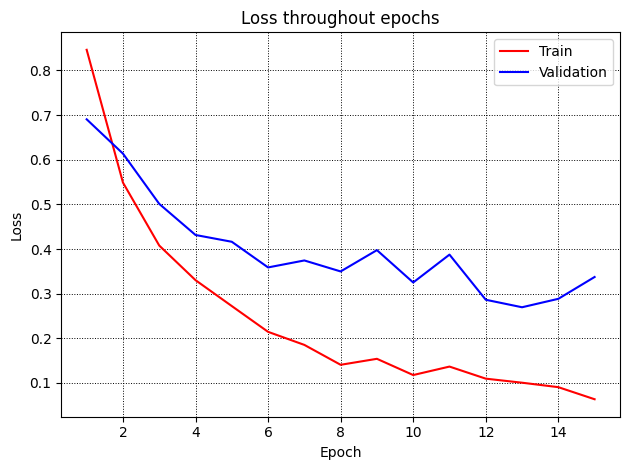

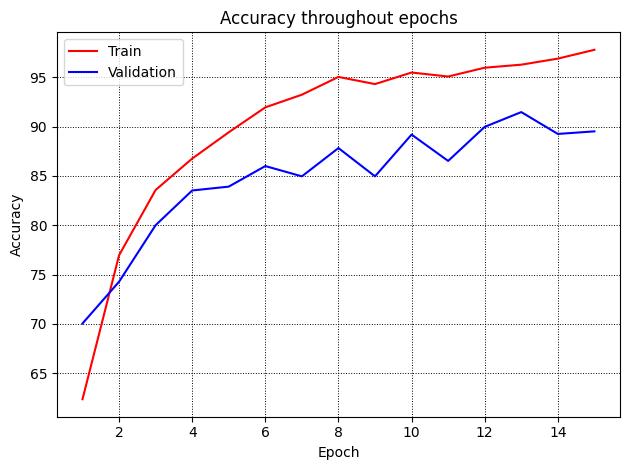

<Figure size 640x480 with 0 Axes>

In [ ]:
fit_model(vgg_model, train_dataloader, val_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=20, save_folder='/content/save', epochs_early_stop=2)

## SENet

In [ ]:
senet_model = senet.MySenet(torchvision.models.squeezenet1_0(pretrained=True), 4, neurons_reducer_block=32, n_feat_conv=86528)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(senet_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 56.4MB/s]


INFO:Train-Logger:Starting the training phase
INFO:Train-Logger:Early stopping is set using the number of epochs without improvement
INFO:Train-Logger:The model will be trained from scratch
INFO:Train-Logger:The training will be carry out using 1 GPU:
INFO:Train-Logger:Tesla T4


Training...


Epoch 1/20: 100%|#####################################| 224/224 [00:18<00:00, 12.02it/s, loss=0.943]



Evaluating...


100%|###################################################| 48/48 [00:03<00:00, 12.56it/s, loss=0.766]
INFO:Train-Logger:Metrics for epoch 1 out of 20
- Train
-- Loss: 0.943
-- Acc: 59.361
-- Top 2 acc: 84.989

- Validation
-- Loss: 0.766
-- Acc: 66.927
-- Top 2 acc: 91.667
-- Balanced accuracy: 0.554
-- AUC: 0.900

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.766
-- Best loss so far: 0.766 on epoch 1



Training...


Epoch 2/20: 100%|#####################################| 224/224 [00:19<00:00, 11.49it/s, loss=0.565]



Evaluating...


100%|###################################################| 48/48 [00:03<00:00, 12.62it/s, loss=0.576]
INFO:Train-Logger:Metrics for epoch 2 out of 20
- Train
-- Loss: 0.565
-- Acc: 78.488
-- Top 2 acc: 95.215

- Validation
-- Loss: 0.576
-- Acc: 75.065
-- Top 2 acc: 93.750
-- Balanced accuracy: 0.655
-- AUC: 0.942

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.576
-- Best loss so far: 0.576 on epoch 2



Training...


Epoch 3/20: 100%|#####################################| 224/224 [00:19<00:00, 11.59it/s, loss=0.403]



Evaluating...


100%|###################################################| 48/48 [00:03<00:00, 12.61it/s, loss=0.506]
INFO:Train-Logger:Metrics for epoch 3 out of 20
- Train
-- Loss: 0.403
-- Acc: 84.891
-- Top 2 acc: 97.517

- Validation
-- Loss: 0.506
-- Acc: 77.930
-- Top 2 acc: 96.354
-- Balanced accuracy: 0.723
-- AUC: 0.957

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.506
-- Best loss so far: 0.506 on epoch 3



Training...


Epoch 4/20: 100%|#####################################| 224/224 [00:19<00:00, 11.73it/s, loss=0.306]



Evaluating...


100%|###################################################| 48/48 [00:03<00:00, 12.25it/s, loss=0.432]
INFO:Train-Logger:Metrics for epoch 4 out of 20
- Train
-- Loss: 0.306
-- Acc: 88.672
-- Top 2 acc: 98.563

- Validation
-- Loss: 0.432
-- Acc: 82.031
-- Top 2 acc: 97.786
-- Balanced accuracy: 0.773
-- AUC: 0.972

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.432
-- Best loss so far: 0.432 on epoch 4



Training...


Epoch 5/20: 100%|#####################################| 224/224 [00:18<00:00, 12.06it/s, loss=0.235]



Evaluating...


100%|###################################################| 48/48 [00:04<00:00, 10.43it/s, loss=0.392]
INFO:Train-Logger:Metrics for epoch 5 out of 20
- Train
-- Loss: 0.235
-- Acc: 91.908
-- Top 2 acc: 98.982

- Validation
-- Loss: 0.392
-- Acc: 83.529
-- Top 2 acc: 98.633
-- Balanced accuracy: 0.831
-- AUC: 0.980

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.392
-- Best loss so far: 0.392 on epoch 5



Training...


Epoch 6/20: 100%|#####################################| 224/224 [00:18<00:00, 12.00it/s, loss=0.212]



Evaluating...


100%|###################################################| 48/48 [00:04<00:00, 11.51it/s, loss=0.529]
INFO:Train-Logger:Metrics for epoch 6 out of 20
- Train
-- Loss: 0.212
-- Acc: 92.439
-- Top 2 acc: 99.009

- Validation
-- Loss: 0.529
-- Acc: 74.935
-- Top 2 acc: 98.893
-- Balanced accuracy: 0.738
-- AUC: 0.977

- Training info
-- Early stopping counting: 1 max to stop is 2
-- Current LR: 0.001
-- Best loss so far: 0.392 on epoch 5



Training...


Epoch 7/20: 100%|#####################################| 224/224 [00:19<00:00, 11.29it/s, loss=0.180]



Evaluating...


100%|###################################################| 48/48 [00:03<00:00, 12.68it/s, loss=0.335]
INFO:Train-Logger:Metrics for epoch 7 out of 20
- Train
-- Loss: 0.180
-- Acc: 93.331
-- Top 2 acc: 99.247

- Validation
-- Loss: 0.335
-- Acc: 86.133
-- Top 2 acc: 99.023
-- Balanced accuracy: 0.772
-- AUC: 0.980

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.335
-- Best loss so far: 0.335 on epoch 7



Training...


Epoch 8/20: 100%|#####################################| 224/224 [00:19<00:00, 11.47it/s, loss=0.169]



Evaluating...


100%|###################################################| 48/48 [00:03<00:00, 12.47it/s, loss=0.265]
INFO:Train-Logger:Metrics for epoch 8 out of 20
- Train
-- Loss: 0.169
-- Acc: 93.708
-- Top 2 acc: 99.344

- Validation
-- Loss: 0.265
-- Acc: 90.104
-- Top 2 acc: 98.828
-- Balanced accuracy: 0.853
-- AUC: 0.986

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.265
-- Best loss so far: 0.265 on epoch 8



Training...


Epoch 9/20: 100%|#####################################| 224/224 [00:19<00:00, 11.46it/s, loss=0.157]



Evaluating...


100%|###################################################| 48/48 [00:03<00:00, 12.61it/s, loss=0.286]
INFO:Train-Logger:Metrics for epoch 9 out of 20
- Train
-- Loss: 0.157
-- Acc: 93.806
-- Top 2 acc: 99.358

- Validation
-- Loss: 0.286
-- Acc: 89.323
-- Top 2 acc: 99.089
-- Balanced accuracy: 0.851
-- AUC: 0.985

- Training info
-- Early stopping counting: 1 max to stop is 2
-- Current LR: 0.001
-- Best loss so far: 0.265 on epoch 8



Training...


Epoch 10/20: 100%|####################################| 224/224 [00:19<00:00, 11.65it/s, loss=0.130]



Evaluating...


100%|###################################################| 48/48 [00:04<00:00, 11.73it/s, loss=0.224]
INFO:Train-Logger:Metrics for epoch 10 out of 20
- Train
-- Loss: 0.130
-- Acc: 95.201
-- Top 2 acc: 99.693

- Validation
-- Loss: 0.224
-- Acc: 91.797
-- Top 2 acc: 99.219
-- Balanced accuracy: 0.887
-- AUC: 0.988

- Training info
-- Early stopping counting: 0 max to stop is 2
-- Current LR: 0.001
-- New best loss: 0.224
-- Best loss so far: 0.224 on epoch 10



Training...


Epoch 11/20: 100%|####################################| 224/224 [00:18<00:00, 11.99it/s, loss=0.136]



Evaluating...


100%|###################################################| 48/48 [00:04<00:00, 10.62it/s, loss=0.241]
INFO:Train-Logger:Metrics for epoch 11 out of 20
- Train
-- Loss: 0.136
-- Acc: 94.964
-- Top 2 acc: 99.540

- Validation
-- Loss: 0.241
-- Acc: 92.383
-- Top 2 acc: 98.763
-- Balanced accuracy: 0.902
-- AUC: 0.988

- Training info
-- Early stopping counting: 1 max to stop is 2
-- Current LR: 0.001
-- Best loss so far: 0.224 on epoch 10



Training...


Epoch 12/20: 100%|####################################| 224/224 [00:19<00:00, 11.79it/s, loss=0.129]



Evaluating...


100%|###################################################| 48/48 [00:04<00:00, 11.69it/s, loss=0.230]
INFO:Train-Logger:Metrics for epoch 12 out of 20
- Train
-- Loss: 0.129
-- Acc: 95.396
-- Top 2 acc: 99.679

- Validation
-- Loss: 0.230
-- Acc: 91.536
-- Top 2 acc: 99.219
-- Balanced accuracy: 0.894
-- AUC: 0.988

- Training info
-- Early stopping counting: 2 max to stop is 2
-- Current LR: 0.001
-- Best loss so far: 0.224 on epoch 10

INFO:Train-Logger:The early stop trigger was activated. The validation loss 0.224 did not improved for 2 epochs.The training phase was stopped.


Saving history plots in /content/save/history
Saving history CSVs in /content/save/history




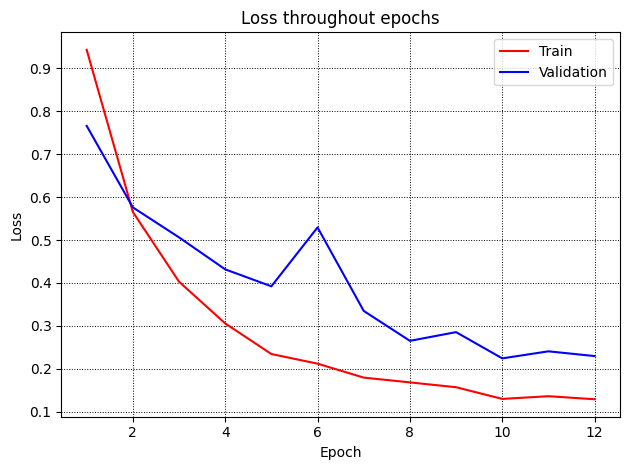

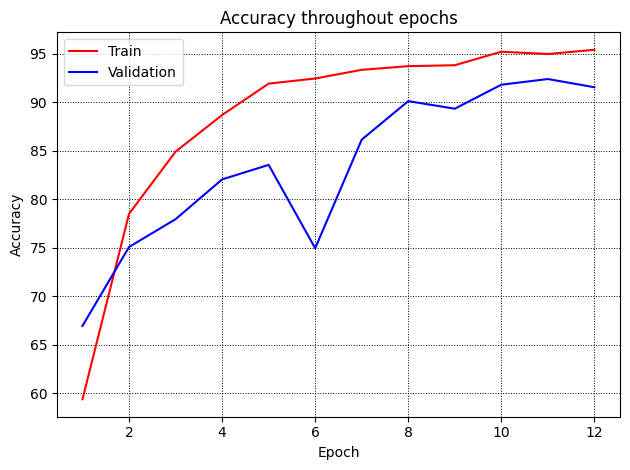

<Figure size 640x480 with 0 Axes>

In [ ]:
fit_model(senet_model, train_dataloader, val_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=20, save_folder='/content/save', epochs_early_stop=2)

## DenseNet

In [ ]:
dense_model = load_model.MyDensenet(torchvision.models.densenet201(pretrained=True), 4, neurons_reducer_block=32, n_feat_conv=1920)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(dense_model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
fit_model(dense_model, train_dataloader, val_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=20, save_folder='/content/save', )

INFO:Train-Logger:Starting the training phase
INFO:Train-Logger:No early stopping is set
INFO:Train-Logger:The model will be trained from scratch
INFO:Train-Logger:The training will be carry out using 1 GPU:
INFO:Train-Logger:Tesla T4


Training...


Epoch 1/20: 100%|#####################################| 224/224 [01:49<00:00,  2.05it/s, loss=0.828]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  4.87it/s, loss=0.757]
INFO:Train-Logger:Metrics for epoch 1 out of 20
- Train
-- Loss: 0.828
-- Acc: 68.039
-- Top 2 acc: 90.206

- Validation
-- Loss: 0.757
-- Acc: 73.177
-- Top 2 acc: 92.708
-- Balanced accuracy: 0.587
-- AUC: 0.909

- Training info
-- Early stopping counting: 0 max to stop is None
-- Current LR: 0.0001
-- New best loss: 0.757
-- Best loss so far: 0.757 on epoch 1



Training...


Epoch 2/20: 100%|#####################################| 224/224 [01:48<00:00,  2.06it/s, loss=0.521]



Evaluating...


100%|###################################################| 48/48 [00:10<00:00,  4.74it/s, loss=0.588]
INFO:Train-Logger:Metrics for epoch 2 out of 20
- Train
-- Loss: 0.521
-- Acc: 86.649
-- Top 2 acc: 97.475

- Validation
-- Loss: 0.588
-- Acc: 79.297
-- Top 2 acc: 96.159
-- Balanced accuracy: 0.797
-- AUC: 0.959

- Training info
-- Early stopping counting: 0 max to stop is None
-- Current LR: 0.0001
-- New best loss: 0.588
-- Best loss so far: 0.588 on epoch 2



Training...


Epoch 3/20: 100%|#####################################| 224/224 [01:48<00:00,  2.06it/s, loss=0.353]



Evaluating...


100%|###################################################| 48/48 [00:10<00:00,  4.76it/s, loss=0.435]
INFO:Train-Logger:Metrics for epoch 3 out of 20
- Train
-- Loss: 0.353
-- Acc: 94.113
-- Top 2 acc: 99.093

- Validation
-- Loss: 0.435
-- Acc: 86.393
-- Top 2 acc: 97.656
-- Balanced accuracy: 0.882
-- AUC: 0.983

- Training info
-- Early stopping counting: 0 max to stop is None
-- Current LR: 0.0001
-- New best loss: 0.435
-- Best loss so far: 0.435 on epoch 3



Training...


Epoch 4/20: 100%|#####################################| 224/224 [01:49<00:00,  2.05it/s, loss=0.289]



Evaluating...


100%|###################################################| 48/48 [00:10<00:00,  4.79it/s, loss=0.365]
INFO:Train-Logger:Metrics for epoch 4 out of 20
- Train
-- Loss: 0.289
-- Acc: 95.466
-- Top 2 acc: 99.484

- Validation
-- Loss: 0.365
-- Acc: 88.151
-- Top 2 acc: 98.177
-- Balanced accuracy: 0.890
-- AUC: 0.985

- Training info
-- Early stopping counting: 0 max to stop is None
-- Current LR: 0.0001
-- New best loss: 0.365
-- Best loss so far: 0.365 on epoch 4



Training...


Epoch 5/20: 100%|#####################################| 224/224 [01:48<00:00,  2.06it/s, loss=0.236]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  4.85it/s, loss=0.278]
INFO:Train-Logger:Metrics for epoch 5 out of 20
- Train
-- Loss: 0.236
-- Acc: 96.847
-- Top 2 acc: 99.581

- Validation
-- Loss: 0.278
-- Acc: 91.862
-- Top 2 acc: 98.893
-- Balanced accuracy: 0.938
-- AUC: 0.988

- Training info
-- Early stopping counting: 0 max to stop is None
-- Current LR: 0.0001
-- New best loss: 0.278
-- Best loss so far: 0.278 on epoch 5



Training...


Epoch 6/20: 100%|#####################################| 224/224 [01:49<00:00,  2.05it/s, loss=0.203]



Evaluating...


100%|###################################################| 48/48 [00:10<00:00,  4.75it/s, loss=0.304]
INFO:Train-Logger:Metrics for epoch 6 out of 20
- Train
-- Loss: 0.203
-- Acc: 97.280
-- Top 2 acc: 99.707

- Validation
-- Loss: 0.304
-- Acc: 90.169
-- Top 2 acc: 98.372
-- Balanced accuracy: 0.932
-- AUC: 0.992

- Training info
-- Early stopping counting: 1 max to stop is None
-- Current LR: 0.0001
-- Best loss so far: 0.278 on epoch 5



Training...


Epoch 7/20: 100%|#####################################| 224/224 [01:48<00:00,  2.06it/s, loss=0.178]



Evaluating...


100%|###################################################| 48/48 [00:09<00:00,  4.86it/s, loss=0.233]
INFO:Train-Logger:Metrics for epoch 7 out of 20
- Train
-- Loss: 0.178
-- Acc: 97.559
-- Top 2 acc: 99.651

- Validation
-- Loss: 0.233
-- Acc: 92.839
-- Top 2 acc: 99.023
-- Balanced accuracy: 0.937
-- AUC: 0.995

- Training info
-- Early stopping counting: 0 max to stop is None
-- Current LR: 0.0001
-- New best loss: 0.233
-- Best loss so far: 0.233 on epoch 7



Training...


Epoch 8/20:  57%|#####################1               | 128/224 [01:02<00:46,  2.05it/s, loss=0.133]


KeyboardInterrupt: 

# Model evaluation

In [ ]:
state = torch.load('/content/save/best-checkpoint/best-checkpoint.pth')
dense_model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

Precision: 0.6953125
Recall: 0.6953125
F1: 0.6953125
Accuracy: 0.6953125
Balanced Accuracy: 0.7963880436951316


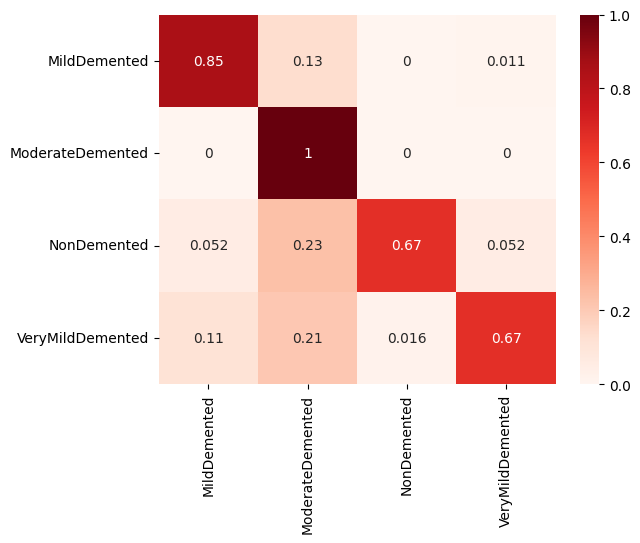

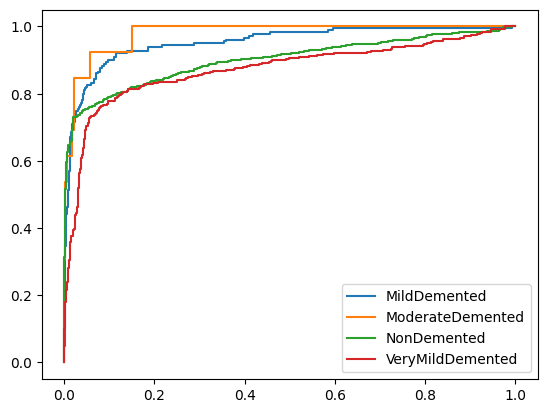

In [ ]:
predicts = []
labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dense_model = dense_model.to(device)

for images, y_true in test_dataloader:
  images, y_true = images.to(device), y_true
  predicts.extend(dense_model(images).detach().cpu().numpy())
  labels.extend(y_true.detach().cpu().numpy())

labels = np.array(labels)
predicts_arg = np.argmax(predicts, axis=1)

onehot_labels = np.zeros((labels.size, labels.max() + 1))
onehot_labels[np.arange(labels.size), labels] = 1

precision = precision_score(labels, predicts_arg, average='micro')
recall = recall_score(labels, predicts_arg, average='micro')
f1 = f1_score(labels, predicts_arg, average='micro')
accuracy = accuracy_score(labels, predicts_arg)
balanced_accuracy = balanced_accuracy_score(labels, predicts_arg)

cm = confusion_matrix(labels, predicts_arg)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Reds', xticklabels=test_labels_cat, yticklabels=test_labels_cat)

plt.figure()
for i in range(4):
  fpr, tpr, thr = roc_curve(onehot_labels[:,i], np.array(predicts)[:,i])
  plt.plot(fpr, tpr)
plt.legend(test_labels_cat)
plt.

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f'Accuracy: {accuracy}')
print(f'Balanced Accuracy: {balanced_accuracy}')